In [184]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

root_dir = "dataset/"

all_csv_paths = []

for subj in sorted(os.listdir(root_dir)):
    subj_dir = os.path.join(root_dir, subj)
    if not os.path.isdir(subj_dir):
        continue

    csv_files = glob.glob(os.path.join(subj_dir, "*.csv"))
    all_csv_paths.extend(csv_files)

print("Number of csv files:", len(all_csv_paths))
print("Some example files:")
for p in all_csv_paths[:5]:
    print("  ", p)


Number of csv files: 61
Some example files:
   dataset/SUBJECT1/C2S1A2T1.csv
   dataset/SUBJECT1/C1S1A2T2.csv
   dataset/SUBJECT1/C2S1A5T2.csv
   dataset/SUBJECT1/C1S1A3T1.csv
   dataset/SUBJECT1/C1S1A5T3.csv


# **INTRODUCE DATASET**

## 1. Overall

UP-Fall Detection Dataset is about:

- Fall Detection

- Human Activity Recognition

- Pose Analysis

## 2. 3D Skeleton

There are 33 joints, save as .CSV

## 3. Class

- Walking

- Standing

- Sitting

- Lying down

- Picking up an object

- Jumping

- Falling forward

- Falling backward

- Falling sideways

- Syncope

- Fall attempt

# 0. Load csv file

In [185]:
def load_skeleton_csv(csv_path: str):
    """
    Read a skeleton CSV file.
    Returns:
      - skeleton: np.ndarray shape (T, 33, 3)
      - label: int (from the LABEL column)
    """
    df = pd.read_csv(csv_path)

    # last column is LABEL
    label = int(df["LABEL"].iloc[0])

    # all coordinate columns (Joint1_X ... Joint33_Z) are from the first column to the one before LABEL
    coord_cols = df.columns[:-1]
    coords = df[coord_cols].values      # (T, 33*3)

    T = coords.shape[0]
    C = 3
    V = 33
    assert coords.shape[1] == V * C, "Number of columns does not match 33 joints * 3"

    skeleton = coords.reshape(T, V, C).astype(np.float32)  # (T, 33, 3)
    return skeleton, label


## Check size

In [146]:
test_csv = glob.glob(os.path.join(root_dir, "SUBJECT1", "*.csv"))[0]
seq, lab = load_skeleton_csv(test_csv)
seq.shape, lab


((100, 33, 3), 0)

## Visualize dataset

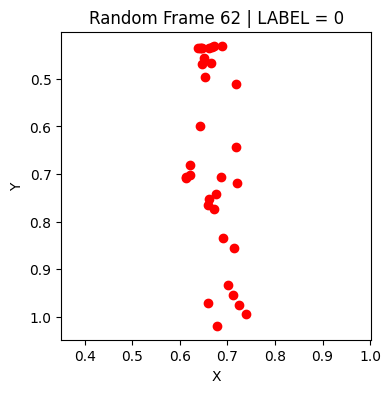

In [186]:
seq, lab = load_skeleton_csv(csv_path)   # seq: (T,33,3)

def plot_skeleton_2d(frame, label=None, title_prefix="Skeleton 2D"):
    x = frame[:, 0]
    y = frame[:, 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c="red")
    plt.gca().invert_yaxis()
    plt.axis("equal")

    title = f"{title_prefix}"
    if label is not None:
        title += f" | LABEL = {label}"

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


import numpy as np
idx = np.random.randint(0, seq.shape[0])
frame = seq[idx]
plot_skeleton_2d(frame, label=lab, title_prefix=f"Random Frame {idx}")



## Dataset with cropping/padding window T

In [187]:
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class SkeletonSequenceDataset(Dataset):
    def __init__(self, root_dir: str, window_size: int = 64):
        """
        window_size: fixed number of frames for each sample (T')
        """
        self.root_dir = root_dir
        self.window_size = window_size

        self.samples = []  # list of csv_path

        for subj in sorted(os.listdir(root_dir)):
            subj_dir = os.path.join(root_dir, subj)
            if not os.path.isdir(subj_dir):
                continue

            for csv_path in glob.glob(os.path.join(subj_dir, "*.csv")):
                self.samples.append(csv_path)

        print("Total CSV files:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        csv_path = self.samples[idx]
        seq, label = load_skeleton_csv(csv_path)  # (T, 33, 3)
        T, V, C = seq.shape

        # normalize length T
        W = self.window_size
        if T > W:
            start = np.random.randint(0, T - W + 1)
            seq = seq[start:start+W]
        elif T < W:
            pad_len = W - T
            pad = np.zeros((pad_len, V, C), dtype=np.float32)
            seq = np.concatenate([seq, pad], axis=0)

        # now seq is always (W, V, C)
        return torch.from_numpy(seq), torch.tensor(label, dtype=torch.long)


## Check

In [149]:
dataset = SkeletonSequenceDataset(root_dir, window_size=64)
seq0, lab0 = dataset[0]
seq0.shape, lab0


Total CSV files: 61


(torch.Size([64, 33, 3]), tensor(0))

## Slipt train/val dataset

In [150]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(dataset))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

train_subset = torch.utils.data.Subset(dataset, train_idx)
val_subset = torch.utils.data.Subset(dataset, val_idx)

BATCH_SIZE = 32

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

len(train_loader), len(val_loader)


(2, 1)

# *1. ST-GCN*

## 1.1. PoseAugmenter

In [ ]:
class PoseAugmenter:
    """Real-time pose data augmentation with rotation, noise, and flipping."""
    def __init__(self, rotation_range: float = 0.1, noise_scale_factor: float = 0.005):
        self.rotation_range = rotation_range
        self.noise_scale_factor = noise_scale_factor

    def run(self, sequence, run_horizontal_flip: bool = False):
        if run_horizontal_flip:
            sequence = self.horizontal_flip_prob(sequence)
        sequence = self.rotate_sequence(sequence)
        sequence = self.distort_sequence(sequence)
        return sequence

    def rotate_sequence(self, sequence: torch.Tensor) -> torch.Tensor:
        device = sequence.device
        theta = np.random.uniform(-self.rotation_range, self.rotation_range)
        rotation_matrix = torch.tensor([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ], dtype=torch.float32, device=device)

        xy_coords = sequence[..., :2]         
        original_shape = xy_coords.shape
        xy_coords = xy_coords.reshape(-1, 2)
        rotated_coords = torch.matmul(xy_coords, rotation_matrix.T)
        rotated_coords = rotated_coords.reshape(original_shape)

        augmented_sequence = sequence.clone()
        augmented_sequence[..., :2] = rotated_coords
        return augmented_sequence

    def distort_sequence(self, sequence: torch.Tensor):
        return sequence + torch.randn_like(sequence) * self.noise_scale_factor

    def horizontal_flip(self, sequence: torch.Tensor):
        out = sequence.detach().clone()
        out[..., 0] = 1 - out[..., 0]  # only correct if x is normalized [0,1]
        return out

    def horizontal_flip_prob(self, sequence: torch.Tensor, prob: float = 0.1):
        return self.horizontal_flip(sequence) if np.random.uniform(0, 1) < prob else sequence


## 1.2. SpatialGraphConv

In [ ]:
import torch.nn as nn

class SpatialGraphConv(nn.Module):
    """Spatial Graph Convolution layer."""
    def __init__(self, in_channels, out_channels, graph_nodes):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)

        # learnable adjacency matrix (graph_nodes x graph_nodes)
        self.A = nn.Parameter(torch.FloatTensor(graph_nodes, graph_nodes))
        nn.init.xavier_uniform_(self.A)

    def forward(self, x):
        # x: (N, C, T, V)
        N, C, T, V = x.size()
        A = torch.softmax(self.A, dim=1)       # (V, V)

        # (N,T,V,C) -> (N*T, V, C)
        x_space = x.permute(0, 2, 3, 1).contiguous().view(N * T, V, C)
        x_space = torch.matmul(A, x_space)     # (N*T, V, C)

        x_space = x_space.view(N, T, V, C).permute(0, 3, 1, 2)  # (N, C, T, V)

        x = self.conv(x_space)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

## 1.3. ST-GCN block

In [ ]:
class STGCNBlock(nn.Module):
    """
    ST-GCN block: Spatial GCN + Temporal Conv + Residual.
    Input/Output: (N, C_in, T, V) -> (N, C_out, T', V)
    """
    def __init__(self, in_channels, out_channels, graph_nodes, stride=1, residual=True):
        super().__init__()

        # Spatial GCN
        self.gcn = SpatialGraphConv(in_channels, out_channels, graph_nodes)

        # Temporal Conv (TCN)
        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=(9, 1),   # kernel along T = 9, along V = 1
                stride=(stride, 1),
                padding=(4, 0)        # keep almost the same T (or T/stride)
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(p=0.2),
        )

        # Residual branch
        if not residual:
            self.residual = lambda x: 0
        else:
            if in_channels == out_channels and stride == 1:
                # identity
                self.residual = lambda x: x
            else:
                # matching C and T (stride)
                self.residual = nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        out_channels,
                        kernel_size=1,
                        stride=(stride, 1)
                    ),
                    nn.BatchNorm2d(out_channels)
                )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # x: (N, C_in, T, V)
        res = self.residual(x)          # (N, C_out, T', V)

        x = self.gcn(x)                 # (N, C_out, T, V)
        x = self.tcn(x)                 # (N, C_out, T', V)

        x = x + res                     # residual add
        x = self.relu(x)
        return x


## 1.4. ST-GCN

In [ ]:
class STGCN(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,      # X,Y,Z
        num_class: int = 11,       # action classes
        graph_nodes: int = 33,
        use_augmentation: bool = True
    ):
        super().__init__()

        self.use_augmentation = use_augmentation
        self.augmenter = PoseAugmenter() if use_augmentation else None

        # BatchNorm on (C * V) 
        self.data_bn = nn.BatchNorm1d(in_channels * graph_nodes)

        # ST-GCN blocks
        self.stgcn1 = STGCNBlock(
            in_channels=in_channels,
            out_channels=64,
            graph_nodes=graph_nodes,
            stride=1,
            residual=False    # first block does not use residual identity
        )

        self.stgcn2 = STGCNBlock(
            in_channels=64,
            out_channels=64,
            graph_nodes=graph_nodes,
            stride=1,
            residual=True
        )

        self.stgcn3 = STGCNBlock(
            in_channels=64,
            out_channels=128,
            graph_nodes=graph_nodes,
            stride=2,         # downsample T by 2
            residual=True
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),   # (N, C, 1, 1)
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_class)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (N, T, V, C)
        """
        if self.training and self.use_augmentation:
            x = self.augmenter.run(x)

        N, T, V, C = x.size()
        # (N, T, V, C) -> (N, C*V, T) -> BN -> (N, C, T, V)
        x = x.permute(0, 3, 2, 1).contiguous()   # (N, C, V, T)
        x = x.view(N, C * V, T)
        x = self.data_bn(x)
        x = x.view(N, C, V, T).permute(0, 1, 3, 2).contiguous()  # (N, C, T, V)

        # ST-GCN blocks
        x = self.stgcn1(x)   # (N, 64, T, V)
        x = self.stgcn2(x)   # (N, 64, T, V)
        x = self.stgcn3(x)   # (N, 128, T', V)

        # Classifier
        out = self.classifier(x)  # (N, num_class)
        return out

## 1.5. ST-GCN architecture overall

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

NUM_CLASSES = 11

model = STGCN(
    in_channels=3,
    num_class=NUM_CLASSES,
    graph_nodes=33,
    use_augmentation=True
).to(device)

model

STGCN(
  (data_bn): BatchNorm1d(99, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stgcn1): STGCNBlock(
    (gcn): SpatialGraphConv(
      (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (tcn): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout(p=0.2, inplace=False)
    )
    (relu): ReLU(inplace=True)
  )
  (stgcn2): STGCNBlock(
    (gcn): SpatialGraphConv(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

## 1.6. Train&evaluate functions

In [156]:
import torch
import torch.nn as nn
import numpy as np

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for sequences, labels in loader:
        sequences = sequences.to(device)            # (N, T, V, C)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(sequences)                 # (N, num_class)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * sequences.size(0)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, labels in loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * sequences.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch}/{epochs}]")
        print(f"  Train Loss: {train_loss:.4f}  |  Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f}  |  Val   Acc: {val_acc:.4f}")
        print("-" * 50)

    return history


## 1.7. Run

In [ ]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    lr=0.001,
    device=device
)

Epoch [1/20]
  Train Loss: 2.4897  |  Train Acc: 0.0625
  Val   Loss: 2.3358  |  Val   Acc: 0.0000
--------------------------------------------------
Epoch [2/20]
  Train Loss: 2.0065  |  Train Acc: 0.3542
  Val   Loss: 2.2108  |  Val   Acc: 1.0000
--------------------------------------------------
Epoch [3/20]
  Train Loss: 1.5452  |  Train Acc: 0.7292
  Val   Loss: 1.9869  |  Val   Acc: 1.0000
--------------------------------------------------
Epoch [4/20]
  Train Loss: 1.1796  |  Train Acc: 0.9167
  Val   Loss: 1.6763  |  Val   Acc: 1.0000
--------------------------------------------------
Epoch [5/20]
  Train Loss: 0.8098  |  Train Acc: 0.9583
  Val   Loss: 1.3384  |  Val   Acc: 1.0000
--------------------------------------------------
Epoch [6/20]
  Train Loss: 0.6018  |  Train Acc: 1.0000
  Val   Loss: 1.0361  |  Val   Acc: 1.0000
--------------------------------------------------
Epoch [7/20]
  Train Loss: 0.5530  |  Train Acc: 0.9792
  Val   Loss: 0.7321  |  Val   Acc: 1.0000
-

## 1.8. Loss & Accuracy

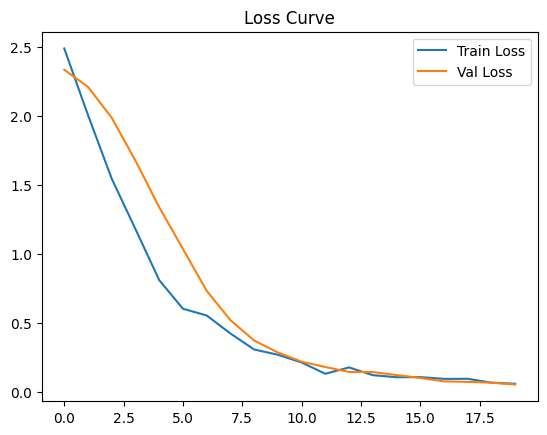

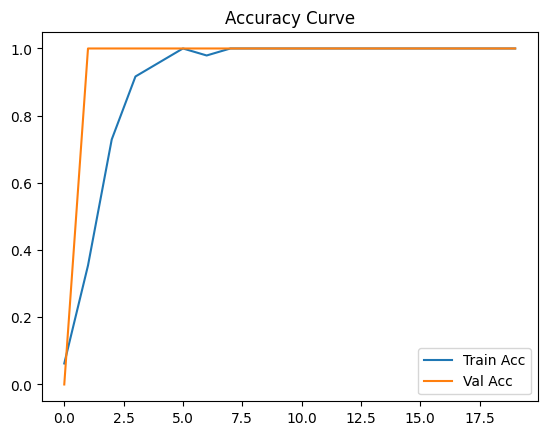

In [158]:
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


## Build bone based on KNN joints due to dataset don't have bone

In [ ]:
def load_skeleton_from_csv(csv_path: str):
    df = pd.read_csv(csv_path)
    coord_cols = df.columns[:-1]      # remove LABEL
    coords = df[coord_cols].values    # (T, 33*3)

    T = coords.shape[0]
    V = 33
    C = 3
    seq = coords.reshape(T, V, C).astype(np.float32)
    return seq


In [ ]:
def build_knn_graph_from_csv(csv_path: str, k: int = 2):
    """
    Create adjacency A (V,V) and bone_pairs (list of (src,dst))
    by:
      - computing mean pose
      - k-nearest neighbors for each joint
      - directing bones from joint closer to center -> joint farther from center
    """
    seq = load_skeleton_from_csv(csv_path)   # (T, V, 3)
    T, V, C = seq.shape

    # Mean pose: (V,3)
    mean_pose = seq.mean(axis=0)

    # Compute distances between joints: (V,V)
    dists = np.linalg.norm(
        mean_pose[None, :, :] - mean_pose[:, None, :],
        axis=-1
    )

    # Create undirected edges using k-NN for each joint
    edges = set()
    for i in range(V):
        # sort index by distance, exclude itself (index 0)
        nn_idx = np.argsort(dists[i])[1:k+1]
        for j in nn_idx:
            a, b = sorted((i, j))
            edges.add((a, b))

    edges = sorted(list(edges))  # list of (i,j), 0-based

    # Tạo adjacency A
    A = np.zeros((V, V), dtype=np.float32)
    for i, j in edges:
        A[i, j] = 1.0
        A[j, i] = 1.0

    # Determine bone direction: from joint closer to center (body centroid) to joint farther from center
    centroid = mean_pose.mean(axis=0)                 # (3,)
    radii = np.linalg.norm(mean_pose - centroid, axis=1)  # (V,)

    bone_pairs = []
    for i, j in edges:
        if radii[i] <= radii[j]:
            src, dst = i, j
        else:
            src, dst = j, i
        bone_pairs.append((src, dst))

    # Convert to torch
    A_torch = torch.from_numpy(A)   # (V,V)

    return A_torch, bone_pairs


## Test & visualize

In [188]:
csv_path = "dataset/SUBJECT1/C1S1A1T1.csv"
A, bone_pairs = build_knn_graph_from_csv(csv_path, k=2)

print("Adjacency shape:", A.shape)      # (33, 33)
print("Number of edges:", len(bone_pairs))
print("First 10 bone_pairs (0-based index):")
print(bone_pairs[:10])


Adjacency shape: torch.Size([33, 33])
Number of edges: 45
First 10 bone_pairs (0-based index):
[(np.int64(9), 0), (np.int64(10), 0), (1, np.int64(4)), (1, np.int64(5)), (np.int64(3), 2), (np.int64(8), 2), (7, np.int64(3)), (np.int64(8), 3), (4, np.int64(5)), (4, np.int64(6))]


In [ ]:
def plot_skeleton_graph_2d(csv_path, bone_pairs, title="K-NN Skeleton Graph 2D"):
    # 1) load sequence
    seq = load_skeleton_from_csv(csv_path)   # (T, V, 3)
    T, V, C = seq.shape

    # 2) Mean pose
    mean_pose = seq.mean(axis=0)             # (V, 3)
    x = mean_pose[:, 0]
    y = mean_pose[:, 1]

    plt.figure(figsize=(5, 5))

    # 3) Plot bones from bone_pairs
    for (src, dst) in bone_pairs:
        xs = [x[src], x[dst]]
        ys = [y[src], y[dst]]
        plt.plot(xs, ys, "k-", linewidth=1)

    # 4) Plot joints
    plt.scatter(x, y, c="red", s=25)

    # Print joint indices on the plot:
    for i in range(V):
        plt.text(x[i] + 0.005, y[i] + 0.005, str(i), fontsize=8)

    plt.gca().invert_yaxis()
    plt.axis("equal")
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


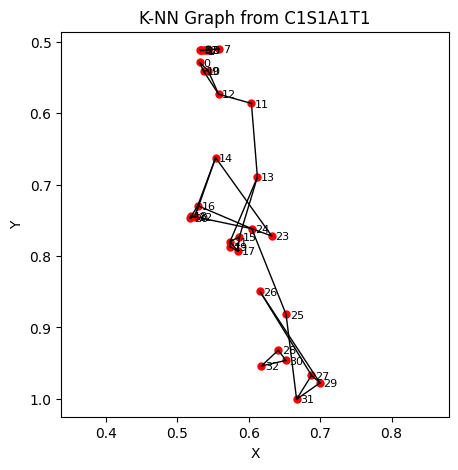

In [163]:
csv_path = "dataset/SUBJECT1/C1S1A1T1.csv"
plot_skeleton_graph_2d(csv_path, bone_pairs, title="K-NN Graph from C1S1A1T1")


# *2. AS-GCN*

## 2.1. ApaptiveGraph convolution

In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdaptiveGraphConv(nn.Module):
    """
    Adaptive Graph Convolution:
    - A_static: physical graph
    - B: learnable 
    - C: data-dependent (each sample has its own graph)
    Input x: (N, C_in, T, V)
    Output: (N, C_out, T, V)
    """
    def __init__(self, in_channels, out_channels, A_static: torch.Tensor,
                 coff_embedding: int = 4, use_adaptive: bool = True):
        super().__init__()
        assert A_static.size(0) == A_static.size(1), "A must be square (V x V)"
        self.V = A_static.size(0)

        # A_physical (no train)
        self.A_static = nn.Parameter(A_static.clone(), requires_grad=False)  # (V,V)

        # B: learnable adjacency
        self.use_adaptive = use_adaptive
        if use_adaptive:
            self.B = nn.Parameter(torch.zeros_like(self.A_static))
        else:
            self.register_parameter("B", None)

        # Embedding to compute C (data-dependent)
        inter_channels = max(1, out_channels // coff_embedding)
        self.theta = nn.Conv2d(in_channels, inter_channels, kernel_size=1)
        self.phi = nn.Conv2d(in_channels, inter_channels, kernel_size=1)

        # 1x1 conv to mix features after graph multiplication
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # x: (N, C_in, T, V)
        N, C, T, V = x.size()
        assert V == self.V

        # ----- 1) C: data-dependent graph (N,V,V) -----
        # Use mean over T
        # f_in -> (N, inter, T, V)
        theta_x = self.theta(x).mean(dim=2)    # (N, inter, V)
        phi_x   = self.phi(x).mean(dim=2)      # (N, inter, V)

        # (N, V, inter) x (N, inter, V) -> (N, V, V)
        theta_x = theta_x.permute(0, 2, 1)     # (N, V, inter)
        C_mat = torch.matmul(theta_x, phi_x)   # (N, V, V)
        C_mat = F.softmax(C_mat, dim=-1)       # normalize theo dim V

        # ----- 2) A_total = A_static + B + C -----
        A = self.A_static
        if self.use_adaptive and self.B is not None:
            A = A + self.B                     # (V, V)

        A = A.unsqueeze(0)                     # (1, V, V)
        A_total = A + C_mat                    # (N, V, V)

        # ----- 3) Apply graph conv with A_total -----
        # x: (N, C, T, V) -> (N, T, V, C) -> (N*T, V, C)
        x_perm = x.permute(0, 2, 3, 1).contiguous()
        x_flat = x_perm.view(N * T, V, C)      # (N*T, V, C)

        # A_total: (N, V, V) -> (N*T, V, V) (repeat over T)
        A_expand = A_total.repeat_interleave(T, dim=0)  # (N*T, V, V)

        x_g = torch.bmm(A_expand, x_flat)      # (N*T, V, C)

        # back to (N, C, T, V)
        x_g = x_g.view(N, T, V, C).permute(0, 3, 1, 2).contiguous()

        # ----- 4) 1x1 conv + BN + ReLU -----
        out = self.conv(x_g)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        return out


## 2.2. AGCN

In [193]:
class AGCNBlock(nn.Module):
    """
    AGCN block: AdaptiveGraphConv (spatial) + Temporal Conv + Residual
    Input/Output: (N, C_in, T, V) -> (N, C_out, T', V)
    """
    def __init__(self, in_channels, out_channels, A_static,
                 stride=1, residual=True):
        super().__init__()

        self.gcn = AdaptiveGraphConv(
            in_channels=in_channels,
            out_channels=out_channels,
            A_static=A_static
        )

        # Temporal Conv
        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=(9, 1),
                stride=(stride, 1),
                padding=(4, 0)
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(p=0.2)
        )

        if not residual:
            self.residual = lambda x: 0
        else:
            if in_channels == out_channels and stride == 1:
                self.residual = lambda x: x
            else:
                self.residual = nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        out_channels,
                        kernel_size=1,
                        stride=(stride, 1)
                    ),
                    nn.BatchNorm2d(out_channels)
                )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # x: (N, C_in, T, V)
        res = self.residual(x)
        x = self.gcn(x)       # (N, C_out, T, V)
        x = self.tcn(x)       # (N, C_out, T', V)
        x = x + res
        x = self.relu(x)
        return x


## 2.3. Joint-only GCN

In [194]:
class AGCN(nn.Module):
    """
    Adaptive Graph Convolutional Network 
    Input: (N, T, V, C)
    Output: (N, num_class)
    """
    def __init__(self,
                 in_channels: int,
                 num_class: int,
                 A_static: torch.Tensor,
                 graph_nodes: int,
                 use_augmentation: bool = True):
        super().__init__()
        self.V = graph_nodes
        self.use_augmentation = use_augmentation
        self.augmenter = PoseAugmenter() if use_augmentation else None

        # Data BN 
        self.data_bn = nn.BatchNorm1d(in_channels * graph_nodes)

        # 3 block AGCN
        self.block1 = AGCNBlock(in_channels, 64,  A_static, stride=1, residual=False)
        self.block2 = AGCNBlock(64,          64,  A_static, stride=1, residual=True)
        self.block3 = AGCNBlock(64,          128, A_static, stride=2, residual=True)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_class)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (N, T, V, C)
        """
        if self.training and self.use_augmentation:
            x = self.augmenter.run(x)

        N, T, V, C = x.size()
        assert V == self.V

        # (N, T, V, C) -> (N, C*V, T) -> BN -> (N, C, T, V)
        x = x.permute(0, 3, 2, 1).contiguous()   # (N, C, V, T)
        x = x.view(N, C * V, T)
        x = self.data_bn(x)
        x = x.view(N, C, V, T).permute(0, 1, 3, 2).contiguous()  # (N, C, T, V)

        x = self.block1(x)   # (N, 64,  T,  V)
        x = self.block2(x)   # (N, 64,  T,  V)
        x = self.block3(x)   # (N, 128, T', V)

        out = self.classifier(x)   # (N, num_class)
        return out


## 2.4. Bone input

In [195]:
def joints_to_bones(joints: torch.Tensor, bone_pairs, device=None):
    """
    joints: (N, T, V, C)
    bone_pairs: list[(src, dst)], length ~ V-1
    Returns:
        bones: (N, T, V, C) – each joint is the bone vector entering it (or 0 if none)
    """
    if device is None:
        device = joints.device

    N, T, V, C = joints.size()
    bones = torch.zeros_like(joints)

    for (src, dst) in bone_pairs:
        # bone vector = joint_dst - joint_src
        bones[:, :, dst, :] = joints[:, :, dst, :] - joints[:, :, src, :]

    return bones.to(device)


## 2.5. AS-GCN

In [196]:
class ASGCN(nn.Module):
    """
    Two-Stream Adaptive GCN:
    - joint_stream: joint coordinates
    - bone_stream: bone vectors
    """
    def __init__(self,
                 in_channels: int,
                 num_class: int,
                 A_static: torch.Tensor,
                 graph_nodes: int,
                 bone_pairs,
                 use_augmentation: bool = True):
        super().__init__()
        self.V = graph_nodes
        self.bone_pairs = bone_pairs

        self.joint_stream = AGCN(
            in_channels=in_channels,
            num_class=num_class,
            A_static=A_static,
            graph_nodes=graph_nodes,
            use_augmentation=use_augmentation
        )

        self.bone_stream = AGCN(
            in_channels=in_channels,          # bone vectors
            num_class=num_class,
            A_static=A_static,
            graph_nodes=graph_nodes,
            use_augmentation=use_augmentation
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (N, T, V, C) – joint coordinates
        """
        # joint stream
        joint_logits = self.joint_stream(x)

        # bone stream
        bones = joints_to_bones(x, self.bone_pairs, device=x.device)
        bone_logits  = self.bone_stream(bones)

        # Fuse two streams
        out = joint_logits + bone_logits
        return out


## 2.6. AS-GCN overall architecture

In [197]:
NUM_CLASSES = 11
V = 33  # số joint

model = ASGCN(
    in_channels=3,
    num_class=NUM_CLASSES,
    A_static=A,         
    graph_nodes=V,
    bone_pairs=bone_pairs,
    use_augmentation=True
).to(device)

model


ASGCN(
  (joint_stream): AGCN(
    (data_bn): BatchNorm1d(99, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1): AGCNBlock(
      (gcn): AdaptiveGraphConv(
        (theta): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
        (phi): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
        (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (tcn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0.2, inplace=False)
      )
      (relu): ReLU(inplace=True)
    )
    (block2): AGCNBlock(

## 2.7. Train & Evaluation

In [198]:
import torch.nn as nn
import torch.nn.functional as F

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for sequences, labels in loader:
        # sequences: (N, W, V, 3)
        sequences = sequences.to(device).float()
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(sequences)      # (N, num_class)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * sequences.size(0)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, labels in loader:
            sequences = sequences.to(device).float()
            labels = labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * sequences.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch}/{epochs}]")
        print(f"  Train Loss: {train_loss:.4f}  |  Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f}  |  Val   Acc: {val_acc:.4f}")
        print("-" * 50)

    return history


## 2.8. Run

In [199]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    lr=0.001,
    device=device
)


Epoch [1/20]
  Train Loss: 1.7350  |  Train Acc: 0.5417
  Val   Loss: 1.8896  |  Val   Acc: 1.0000
--------------------------------------------------
Epoch [2/20]
  Train Loss: 0.9070  |  Train Acc: 0.9792
  Val   Loss: 1.4960  |  Val   Acc: 1.0000
--------------------------------------------------
Epoch [3/20]
  Train Loss: 0.4886  |  Train Acc: 1.0000
  Val   Loss: 1.0178  |  Val   Acc: 1.0000
--------------------------------------------------
Epoch [4/20]
  Train Loss: 0.1954  |  Train Acc: 1.0000
  Val   Loss: 0.5555  |  Val   Acc: 1.0000
--------------------------------------------------
Epoch [5/20]
  Train Loss: 0.1428  |  Train Acc: 1.0000
  Val   Loss: 0.2541  |  Val   Acc: 1.0000
--------------------------------------------------
Epoch [6/20]
  Train Loss: 0.0659  |  Train Acc: 1.0000
  Val   Loss: 0.1067  |  Val   Acc: 1.0000
--------------------------------------------------
Epoch [7/20]
  Train Loss: 0.0375  |  Train Acc: 1.0000
  Val   Loss: 0.0488  |  Val   Acc: 1.0000
-

## 2.9. Loss & Accuracy

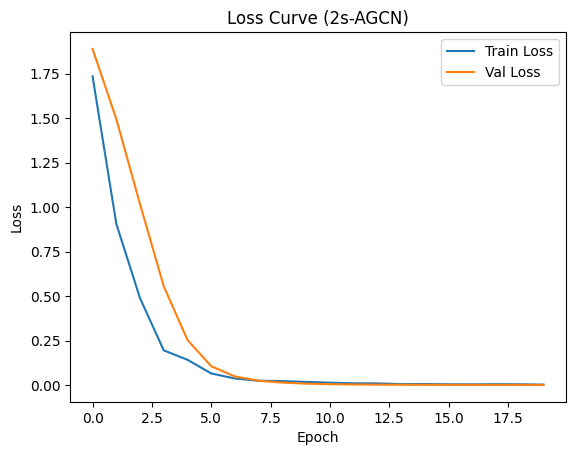

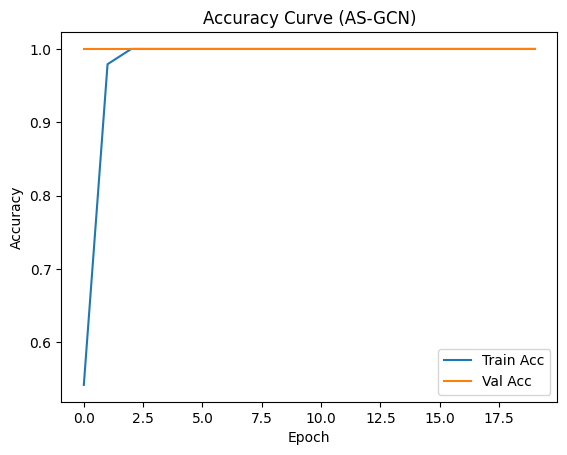

In [200]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.legend()
plt.title("Loss Curve (2s-AGCN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"],   label="Val Acc")
plt.legend()
plt.title("Accuracy Curve (AS-GCN)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
